In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from lifelines import KaplanMeierFitter


In [45]:
# Lectura de los datos
df = pd.read_csv('csv/COVID19_data.csv', index_col='ID')

In [3]:
# Preprocessing of the data
# Deleted column due to too many null/missing values
df.pop('DESTINATION')
# Deleted column due to too many null values (0's)
df.pop('GLUCOSE')

# Deletion of rows with error values for temperature, blood_pres and sat_o2
df = df.drop(df[df['TEMP'] <= 10].index)
df = df.drop(df[df['BLOOD_PRES_SYS'] >= 300].index)
df = df.drop(df[df['BLOOD_PRES_DIAS'] >= 150].index)

# Check which columns have null values
print(df.isnull().any())
print()
# Spit data frame between categorical and numerical variables in order to treat null values in categorical variables
cat_mask = (df.dtypes == object)

cat_cols = df.columns[cat_mask].tolist()

df_cat = df[cat_cols]
df_num = df.drop(cat_cols, axis = 1)

print(df_cat)
print()
print(df_num)

AGE                 True
SEX                 True
DAYS_HOSPITAL      False
DAYS_ICU           False
EXITUS              True
TEMP               False
HEART_RATE         False
SAT_O2             False
BLOOD_PRES_SYS     False
BLOOD_PRES_DIAS    False
dtype: bool

         SEX EXITUS
ID                 
1     FEMALE     NO
2     FEMALE     NO
3       MALE     NO
4       MALE     NO
5       MALE     NO
...      ...    ...
2046  FEMALE    YES
2047  FEMALE    YES
2048  FEMALE     NO
2049  FEMALE    YES
2052  FEMALE     NO

[1551 rows x 2 columns]

        AGE  DAYS_HOSPITAL  DAYS_ICU  TEMP  HEART_RATE  SAT_O2  \
ID                                                               
1      15.0              4         0  37.0           0      92   
2      18.0              4         0  37.3         105      97   
3      21.0              7         0  38.5         112      95   
4      21.0             10         0  39.2         113      97   
5      22.0              4         0  36.3          80 

In [4]:
# Transformation of missing values in categorical data frame

from sklearn.impute import SimpleImputer

imp_cat = SimpleImputer(strategy='most_frequent')
columns = df_cat.columns
index = df_cat.index
df_cat = pd.DataFrame(imp_cat.fit_transform(df_cat), columns = columns, index = index) 

print(df_cat.isnull().any())

SEX       False
EXITUS    False
dtype: bool


In [5]:
# Next we are going to transform the variables to numerical. Due to being both binary variables,
# a value will be assigned to each category for simplicity.
# For Sex 0 = Female, 1 = Male; for Exitus 0 = No, 1 = Yes

from sklearn import preprocessing
from collections import defaultdict

d = defaultdict(preprocessing.LabelEncoder)

df_cat_le = df_cat.apply(lambda col: d[col.name].fit_transform(col))
print(df_cat_le)

      SEX  EXITUS
ID               
1       0       0
2       0       0
3       1       0
4       1       0
5       1       0
...   ...     ...
2046    0       1
2047    0       1
2048    0       0
2049    0       1
2052    0       0

[1551 rows x 2 columns]


In [6]:
# Now we are going to treat missing values in numerical variables

imp_num = SimpleImputer(strategy='mean')
columns = df_num.columns
index = df_num.index
df_num = pd.DataFrame(imp_num.fit_transform(df_num), columns = columns, index = index)

print(df_num.isnull().any())

AGE                False
DAYS_HOSPITAL      False
DAYS_ICU           False
TEMP               False
HEART_RATE         False
SAT_O2             False
BLOOD_PRES_SYS     False
BLOOD_PRES_DIAS    False
dtype: bool


In [7]:
# Now we are going to treat strange values (BLOOD_PRES_SYS = 0, BLOOD_PRES_DIAS = 0, SAT_O2 = 0)
imp_num = SimpleImputer(missing_values=0.0, strategy='mean')
columns = df_num.columns
index = df_num.index
df_tmp = pd.DataFrame(imp_num.fit_transform(df_num), columns = columns, index = index)
# Use BLOOD_PRES and SAT_02 columns
df_num['BLOOD_PRES_SYS'] = df_tmp.pop('BLOOD_PRES_SYS')
df_num['BLOOD_PRES_DIAS'] = df_tmp.pop('BLOOD_PRES_DIAS')
df_num['SAT_O2'] = df_tmp.pop('SAT_O2')

print((0.0 in df_num))
print(df_num)

False
             AGE  DAYS_HOSPITAL  DAYS_ICU  TEMP  HEART_RATE  SAT_O2  \
ID                                                                    
1      15.000000            4.0       0.0  37.0         0.0    92.0   
2      18.000000            4.0       0.0  37.3       105.0    97.0   
3      21.000000            7.0       0.0  38.5       112.0    95.0   
4      21.000000           10.0       0.0  39.2       113.0    97.0   
5      22.000000            4.0       0.0  36.3        80.0    92.0   
...          ...            ...       ...   ...         ...     ...   
2046  101.000000            2.0       0.0  36.8        84.0    95.0   
2047  102.000000            5.0       0.0  36.5        83.0    94.0   
2048  105.000000            4.0       0.0  36.4        74.0    98.0   
2049  106.000000            5.0       0.0  38.2        89.0    98.0   
2052   71.218065            6.0       6.0  36.8       190.0    98.0   

      BLOOD_PRES_SYS  BLOOD_PRES_DIAS  
ID                            

In [8]:
# Merge of the preprocessed data frames

df_preprocessed = pd.merge(left= df_cat_le,
                           right= df_num,
                           on = 'ID')

print(df_preprocessed)

      SEX  EXITUS         AGE  DAYS_HOSPITAL  DAYS_ICU  TEMP  HEART_RATE  \
ID                                                                         
1       0       0   15.000000            4.0       0.0  37.0         0.0   
2       0       0   18.000000            4.0       0.0  37.3       105.0   
3       1       0   21.000000            7.0       0.0  38.5       112.0   
4       1       0   21.000000           10.0       0.0  39.2       113.0   
5       1       0   22.000000            4.0       0.0  36.3        80.0   
...   ...     ...         ...            ...       ...   ...         ...   
2046    0       1  101.000000            2.0       0.0  36.8        84.0   
2047    0       1  102.000000            5.0       0.0  36.5        83.0   
2048    0       0  105.000000            4.0       0.0  36.4        74.0   
2049    0       1  106.000000            5.0       0.0  38.2        89.0   
2052    0       0   71.218065            6.0       6.0  36.8       190.0   

      SAT_O

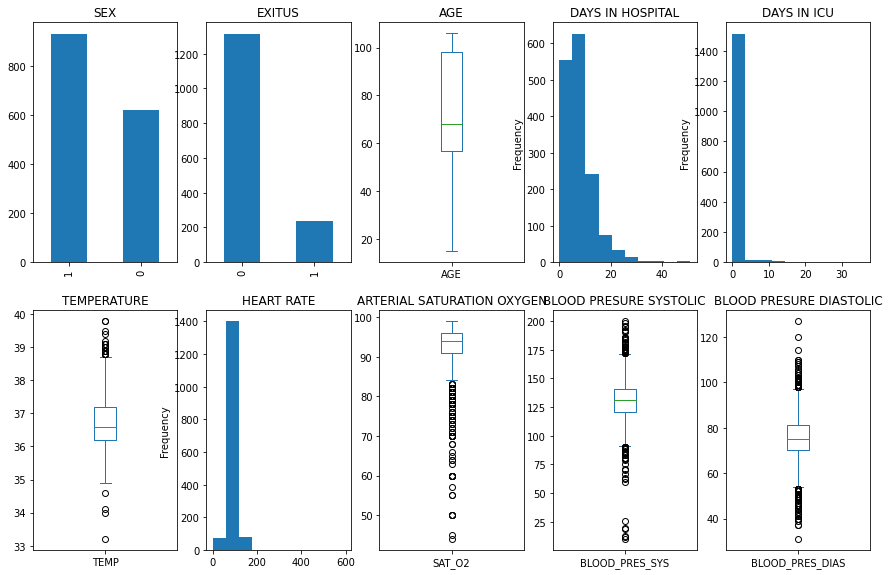

In [47]:
# Exploratory analysis of the data so far

# Distribution of the variables, univariate analysis
# Aqui comentarios respecto a la distribucion de cada variable haciendo hincapie en
# edad, exitus, dias en uci, dias en hospital, gluclosa, saturacion O2 y presion arterial (tanto sistolica como diastolica)
# Descartamos sexo, temperatura y latidos del corazon al ser poco relevantes

plt.figure(figsize=(15,15))

plt.subplot(3,5,1)
df_preprocessed['SEX'].value_counts().plot(kind="bar", title = 'SEX')

plt.subplot(3,5,2)
df_preprocessed["EXITUS"].value_counts().plot(kind="bar", title = 'EXITUS')

plt.subplot(3,5,3)
df_preprocessed['AGE'].plot(kind="box", title = 'AGE')

plt.subplot(3,5,4)
df_preprocessed['DAYS_HOSPITAL'].plot(kind="hist", title = 'DAYS IN HOSPITAL')

plt.subplot(3,5,5)
df_preprocessed['DAYS_ICU'].plot(kind="hist", title = 'DAYS IN ICU')

plt.subplot(3,5,6)
df_preprocessed['TEMP'].plot(kind="box", title = 'TEMPERATURE')

plt.subplot(3,5,7)
df_preprocessed['HEART_RATE'].plot(kind="hist", title = 'HEART RATE')

plt.subplot(3,5,8)
df_preprocessed['SAT_O2'].plot(kind="box", title = 'ARTERIAL SATURATION OXYGEN')

plt.subplot(3,5,9)
df_preprocessed['BLOOD_PRES_SYS'].plot(kind="box", title = 'BLOOD PRESURE SYSTOLIC')

plt.subplot(3,5,10)
df_preprocessed['BLOOD_PRES_DIAS'].plot(kind="box", title = 'BLOOD PRESURE DIASTOLIC')

plt.show()


In [10]:
# Statistical values for each variable
# Aqui comentamos la gran desviacion tipica que presentan los valores clinicos, la tasa de exitus (a mayor mas mueren) y un poco
# los intervalos de edad
df_preprocessed.describe()


,SEX,EXITUS,AGE,DAYS_HOSPITAL,DAYS_ICU,TEMP,HEART_RATE,SAT_O2,BLOOD_PRES_SYS,BLOOD_PRES_DIAS
count,1551.000000,1551.000000,1551.000000,1551.000000,1551.000000,1551.000000,1551.000000,1551.000000,1551.000000,1551.00000
mean,0.600258,0.152160,71.218065,7.948420,0.290135,36.735977,88.253385,92.613153,131.066502,75.09688
std,0.490003,0.359292,20.152968,5.433105,1.990532,0.813821,25.008765,6.422435,19.941586,11.27202
min,0.000000,0.000000,15.000000,0.000000,0.000000,33.200000,0.000000,44.000000,10.000000,31.00000
25%,0.000000,0.000000,57.000000,4.000000,0.000000,36.200000,78.000000,91.000000,121.000000,70.00000
50%,1.000000,0.000000,68.000000,7.000000,0.000000,36.600000,88.000000,94.000000,131.066502,75.09688
75%,1.000000,0.000000,98.000000,10.000000,0.000000,37.200000,100.000000,96.000000,141.000000,81.00000
max,1.000000,1.000000,106.000000,51.000000,36.000000,39.800000,593.000000,99.000000,200.000000,127.00000


In [11]:
# Getting columns for future feature selection 
days_uci_col = df_preprocessed.pop('DAYS_ICU')

exitus_col = df_preprocessed.pop('EXITUS')

In [12]:
# Now we are going to perform a feature selection for icu days

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

fs_k_best_chi2 = SelectKBest(chi2, k=4)
fs_k_best_chi2.fit(df_preprocessed, days_uci_col)
col_filter = fs_k_best_chi2.get_support()
df_k_best_chi2_icu_days = df_preprocessed.iloc[:, col_filter]

print(df_k_best_chi2_icu_days)

             AGE  DAYS_HOSPITAL  HEART_RATE  SAT_O2
ID                                                 
1      15.000000            4.0         0.0    92.0
2      18.000000            4.0       105.0    97.0
3      21.000000            7.0       112.0    95.0
4      21.000000           10.0       113.0    97.0
5      22.000000            4.0        80.0    92.0
...          ...            ...         ...     ...
2046  101.000000            2.0        84.0    95.0
2047  102.000000            5.0        83.0    94.0
2048  105.000000            4.0        74.0    98.0
2049  106.000000            5.0        89.0    98.0
2052   71.218065            6.0       190.0    98.0

[1551 rows x 4 columns]


In [13]:
# Now we are going to perform a feature selection for exitus

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

fs_k_best_chi2 = SelectKBest(chi2, k=4)
fs_k_best_chi2.fit(df_preprocessed, exitus_col)
col_filter = fs_k_best_chi2.get_support()
df_k_best_chi2_existus = df_preprocessed.iloc[:, col_filter]

print(df_k_best_chi2_existus)

             AGE  HEART_RATE  SAT_O2  BLOOD_PRES_DIAS
ID                                                   
1      15.000000         0.0    92.0         75.09688
2      18.000000       105.0    97.0         75.09688
3      21.000000       112.0    95.0         47.00000
4      21.000000       113.0    97.0         75.09688
5      22.000000        80.0    92.0         70.00000
...          ...         ...     ...              ...
2046  101.000000        84.0    95.0         65.00000
2047  102.000000        83.0    94.0         65.00000
2048  105.000000        74.0    98.0         97.00000
2049  106.000000        89.0    98.0         63.00000
2052   71.218065       190.0    98.0         75.09688

[1551 rows x 4 columns]


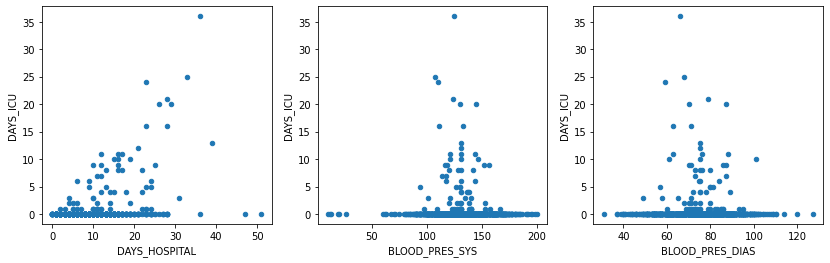

In [14]:
## Bivariate analysis based on the selected features for icu days

# observamos la correlacion entre dias en hospital y dias en uci y la debil correlacion con las demas variables
# nos parece indicar que hay cierta independencia entre ellas como luego se puede ver en el coeficiente de Pearson

df_preprocessed['DAYS_ICU'] = days_uci_col

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
df_preprocessed.plot(kind = "scatter", x = 'DAYS_HOSPITAL', y = 'DAYS_ICU', ax = plt.gca())

plt.subplot(1,3,2)
df_preprocessed.plot(kind = "scatter", x = 'BLOOD_PRES_SYS', y = 'DAYS_ICU', ax = plt.gca())

plt.subplot(1,3,3)
df_preprocessed.plot(kind = "scatter", x = 'BLOOD_PRES_DIAS', y = 'DAYS_ICU', ax = plt.gca())

plt.show()

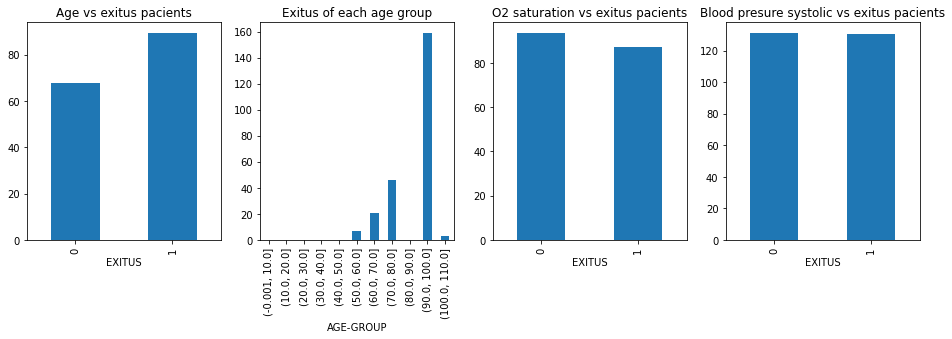

In [38]:
# Bivariate analysis based on the selected features for exitus

# aqui podemos obtener datos mas concluyentes repecto a la media de edad de los pacientes que mueren

df_preprocessed['EXITUS'] = exitus_col

group_df = df_preprocessed.groupby(['EXITUS'])

age_groups = list(range(0, 120, 10))
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119']
df_preprocessed['AGE-GROUP'] = pd.cut(df_preprocessed['AGE'], age_groups, labels, include_lowest=True)
age_group_df = df_preprocessed.groupby(['AGE-GROUP'])

plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
group_df.mean()['AGE'].plot(kind = 'bar', title = 'Age vs exitus patients')

plt.subplot(1,4,2)
age_group_df.sum()['EXITUS'].plot(kind = 'bar', title = '#Exitus patients of each age group')

plt.subplot(1,4,3)
group_df.mean()['SAT_O2'].plot(kind = 'bar', title = 'O2 saturation vs exitus patients')

plt.subplot(1,4,4)
group_df.mean()['BLOOD_PRES_SYS'].plot(kind = 'bar', title = 'Blood presure systolic vs exitus patients')

df_preprocessed.pop('AGE-GROUP')
plt.show()

In [16]:
df_preprocessed.to_csv('csv/covid_preprocessed.csv', sep='\t', encoding='utf-8')

In [17]:
# Pearson correlation coeficients
print(df_preprocessed.corr(method = 'pearson'))

                      SEX       AGE  DAYS_HOSPITAL      TEMP  HEART_RATE  \
SEX              1.000000 -0.128772       0.084339  0.119245    0.025697   
AGE             -0.128772  1.000000       0.014289 -0.141241   -0.231035   
DAYS_HOSPITAL    0.084339  0.014289       1.000000  0.137942    0.004184   
TEMP             0.119245 -0.141241       0.137942  1.000000    0.139281   
HEART_RATE       0.025697 -0.231035       0.004184  0.139281    1.000000   
SAT_O2          -0.069466 -0.183792      -0.137208 -0.043377   -0.072278   
BLOOD_PRES_SYS   0.052269  0.135023      -0.007430  0.041930    0.011008   
BLOOD_PRES_DIAS  0.115121 -0.135203      -0.010455  0.033861    0.179048   
DAYS_ICU         0.064084 -0.052427       0.360571  0.065479    0.037584   
EXITUS           0.041553  0.383271      -0.012502 -0.001965   -0.025259   

                   SAT_O2  BLOOD_PRES_SYS  BLOOD_PRES_DIAS  DAYS_ICU    EXITUS  
SEX             -0.069466        0.052269         0.115121  0.064084  0.041553  
A

<AxesSubplot:xlabel='timeline'>

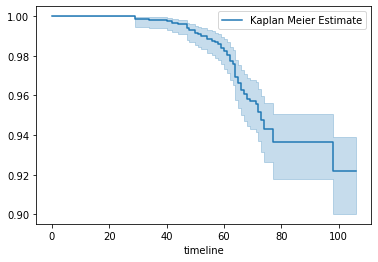

In [18]:
# Kaplan-Meier curve for ICU and AGE

# estan son las curvas que no se interpretar y que deberiamos indicar que no hemos sabido aplicarlas por desconocimiento

kmf = KaplanMeierFitter()

kmf.fit(df_preprocessed['AGE'], df_preprocessed['DAYS_ICU'],label='Kaplan Meier Estimate')

kmf.plot()

<AxesSubplot:xlabel='timeline'>

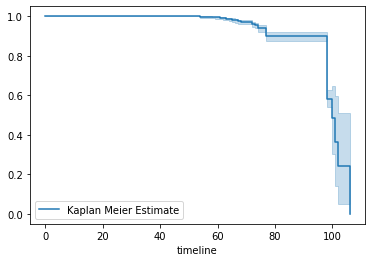

In [19]:
# Kaplan-Meier curve for EXITUS and AGE

kmf = KaplanMeierFitter()

kmf.fit(df_preprocessed['AGE'], df_preprocessed['EXITUS'],label='Kaplan Meier Estimate')

kmf.plot()